In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    # dict(name="base", id="upst1ai-strumpack_Tnorm_x10_match_fluxlim", unnormalise = True), 
    # dict(name="new", id="upst5a-reimplement_AFN_from_upst1ah", unnormalise = True), 
    dict(name="new", id="upstxx-reimplement_AFN_from_upst1ah_test", unnormalise = True), 
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"g3e4f1-lores_widev2_nonortho_xpoint_allf.nc"'
Evaluating non-scalar options not available
  alwayswarn(


- Reading case upstxx-reimplement_AFN_from_upst1ah_test
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# New

In [9]:
def grad_perp(ds, f):

    x = f.bout.ddx() - ds["g_12"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    y = np.zeros_like(x)
    z = - ds["g_23"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    
    if "z" in ds.coords:
        z = f.bout.ddz() + z

    
    return x,y,z
# Units of f divided by x, and x is in Wb=Tm^2
# x is in poloidal flux 
# ddy has no units cause y is angle
# ddx is units of f/Wb?
# z has no units cause z is angle
# DOT PRODUCT IS A CUSTOM OPERATOR WITH METRIC COEFFICIENTS!!

In [10]:
# name = "base"
# df = dfs[name]
# ds = cs[name].ds
# if "t" in ds.sizes: ds = ds.isel(t=-1)
# m = ds.metadata
# Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
# Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
# pn_floor = 1e-8 * 1/100 * Pnorm

# Pnlim = softFloor(ds["Pd"], pn_floor);
# logPnlim = np.log(Pnlim)

# pf_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
# ds["pf_calc"] = (["x", "theta"], pf_xlow.data)

dfs = {}

for name in ["new"]:
    ds = cs[name].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)
    
    m = ds.metadata
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
    pn_floor = 1e-8 * 1/100 * Pnorm

    Pnlim = softFloor(ds["Pd"], pn_floor);
    logPnlim = np.log(Pnlim)

    ds["grad_perp_logPnlim_x_calc"], _, _ = grad_perp(ds, logPnlim)
    
    kappa_n = 5/2 * ds["Dnnd"] * ds["Nd"]
    # eta_n = 2*constants("mass_p") * 2/5 * kappa_n
    eta_n = 2/5 * kappa_n
    
    pf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
    mf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["NVd"], logPnlim)
    ef_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Pd"], logPnlim)
    ef_cond_xlow, _ = Div_a_Grad_perp_fast(ds, kappa_n, ds["Td"]*constants("q_e"))
    
    mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, 2 * eta_n, ds["Vd"])
    # mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, eta_n, ds["Vd"])
    
    ef_adv_xlow *= 5/2
    ef_cond_xlow *= 3/2

    
    ds["pf_adv_calc"] = (["x", "theta"], pf_adv_xlow.data)
    ds["mf_adv_calc"] = (["x", "theta"], mf_adv_xlow.data)
    ds["ef_adv_calc"] = (["x", "theta"], ef_adv_xlow.data)
    ds["ef_cond_calc"] = (["x", "theta"], ef_cond_xlow.data)
    ds["mf_visc_calc"] = (["x", "theta"], mf_visc_xlow.data)
    
    if "fluxlimd_pf_perp" in ds:
        ds["pf_adv_calc_timeslim"] = ds["pf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["mf_adv_calc_timeslim"] = ds["mf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_adv_calc_timeslim"] = ds["ef_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_cond_calc_timeslim"] = ds["ef_cond_calc"] * ds["fluxlimd_ef_perp"]
        ds["mf_visc_calc_timeslim"] = ds["mf_visc_calc"] * ds["fluxlimd_mf_perp"]

    
    dfs[name] = get_1d_radial_data(ds, ["pfd_adv_perp_xlow", "mfd_adv_perp_xlow", "efd_adv_perp_xlow", "efd_cond_perp_xlow", "mfd_visc_perp_xlow",
                                        "dx", "dy", "dz", "g22", "g_33", "g_12", "g_11", "J", "Bxy",
                                        "Nd", "Ne", "Pd", "Td", "Vd", "Vd+",
                                        "Dnnd", "Dnnd_check", "Dmaxd",
                                        "Kdd+_cx", "Sd+_iz", "Kd_diff", "Kd_diff_mfp",
                                        "Vd_perp_x", "Vd_perp_y", "Vd_perp_abs",
                                        "kappa_n_d",
                                        "grad_perp_logPnlim_x_d",
                                        "grad_perp_logPnlim_x_calc", 
                                        "fluxlimd_pf_perp", "fluxlimd_ef_perp", "fluxlimd_mf_perp",
                                        "pf_adv_calc", "mf_adv_calc", "ef_adv_calc", "ef_cond_calc", "mf_visc_calc",
                                        "pf_adv_calc_timeslim", "mf_adv_calc_timeslim", "ef_adv_calc_timeslim", "ef_cond_calc_timeslim", "mf_visc_calc_timeslim",
                                        ], "omp")

    df = dfs[name]
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

    df["dpol"] = df["dy"] * np.sqrt(df["g22"])
    df["dtor"] = df["dz"] * np.sqrt(df["g_33"])
    df["darad"] = df["dpol"] * df["dtor"]
    pn_floor = 1e-8 * 1/100 * Pnorm
    df["Pnlim"] = np.clip(df["Pd"], pn_floor, None)

    df["pflux"] = df["pfd_adv_perp_xlow"] / df["darad"]
    df["logPnlim"] = np.log(df["Pnlim"])
    df["kappa_n"] = 5/2 * df["Dnnd"] * df["Nd"]
    dfs[name] = df

Parameter Dmaxd not found
Parameter kappa_n_d not found


### Dnn

From options: maximum_mfp=10000
From options: pressure_floor=1.60217662e-08
From options: density_floor=1000000000.0


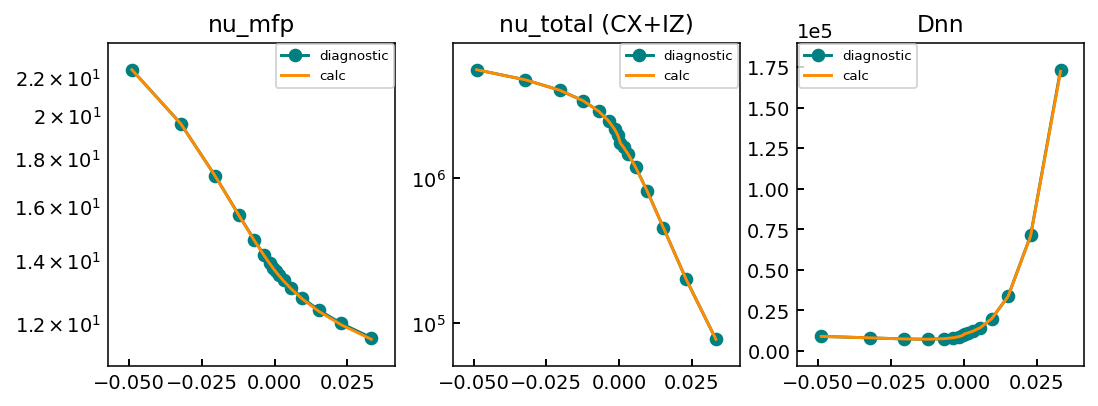

In [11]:
name = "new"

df = dfs[name]
ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)
m = ds.metadata

Mi = 2 * constants("mass_p")
qe = constants("q_e")

maximum_mfp = ds.options["d"]["maximum_mfp"]
pressure_floor = ds.options["d"]["pn_floor"] * m["Nnorm"] * m["Tnorm"] * qe
density_floor = ds.options["d"]["nn_floor"] * m["Nnorm"]
temperature_floor = pressure_floor / density_floor / constants("q_e")

print(f"From options: maximum_mfp={maximum_mfp}")
print(f"From options: pressure_floor={pressure_floor}")
print(f"From options: density_floor={density_floor}")


particle_flux_limit_alpha = 0.2
df["Tnlim"] = softFloor(df["Td"], 0.1)
df["Nnlim"] = softFloor(df["Nd"], density_floor)

df["nu_calc_cx"] = df["Kdd+_cx"] 
df["nu_calc_iz"] = df["Sd+_iz"]/df["Nd"]
df["nu_calc_total"] = df["nu_calc_cx"] + df["nu_calc_iz"]  # Excludes mfp
df["nu_calc_mfp"] = np.sqrt(df["Tnlim"]*qe/Mi) / maximum_mfp


df["grad_corr"] = df["g_12"] / (df["J"] * df["Bxy"])**2
gradPerp = np.gradient(df["logPnlim"], df["dx"].cumsum() * df["grad_corr"])

df["Dnn_calc"] = (df["Tnlim"] * qe/Mi) / (df["nu_calc_total"] + df["nu_calc_mfp"])
df["Dmax_calc"] = particle_flux_limit_alpha * np.sqrt(df["Tnlim"] * qe / Mi) / (df["grad_perp_logPnlim_x_calc"] + 1/df["nu_calc_total"])

fig, axes =plt.subplots(1,3, figsize = (3*3,3))

ax = axes[0]
ax.set_title("nu_mfp")
ax.plot(df["Srad"], df["Kd_diff_mfp"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["nu_calc_mfp"], "-", label = "calc")
ax.set_yscale("log")

ax = axes[1]
ax.set_title("nu_total (CX+IZ)")
ax.plot(df["Srad"], df["Kd_diff"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["nu_calc_total"], "-", label = "calc")
ax.set_yscale("log")

ax = axes[2]
ax.set_title("Dnn")
ax.plot(df["Srad"], df["Dnnd"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")

for ax in axes:
    ax.legend(fontsize = "x-small")

### V_perp

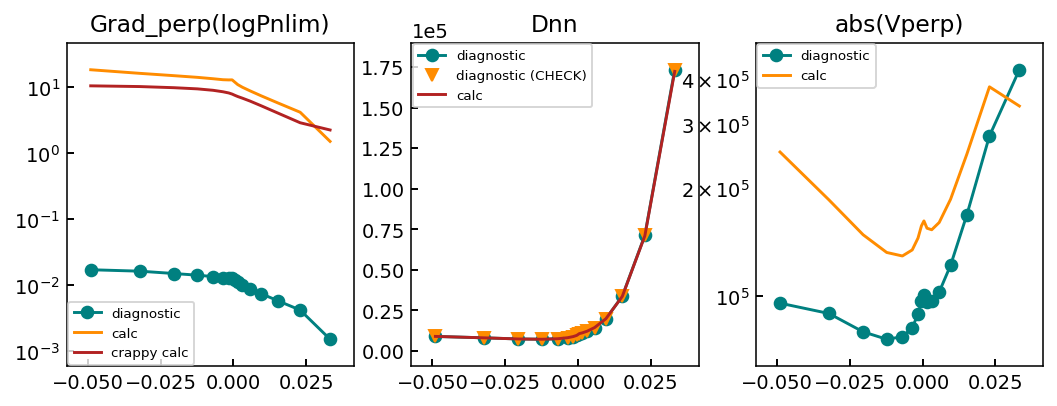

In [12]:
name = "new"

# CORRECTION = m["rho_s0"]
CORRECTION = 1

fig, axes =plt.subplots(1,3, figsize = (3*3,3))

crappy_grad = np.gradient(df["logPnlim"], df["Srad"])
df["Vx_calc"] = -df["Dnnd"] * df["grad_perp_logPnlim_x_calc"] * np.sqrt(df["g_11"])
df["Vabs_calc"] = np.sqrt(df["Vx_calc"]**2)

ax =axes[0]
ax.set_title("Grad_perp(logPnlim)")
ax.plot(df["Srad"], df["grad_perp_logPnlim_x_d"] , "o-", label = "diagnostic")
ax.plot(df["Srad"], df["grad_perp_logPnlim_x_calc"] * CORRECTION, label = "calc")
ax.plot(df["Srad"], crappy_grad * CORRECTION, label = "crappy calc")
ax.set_yscale("log")
ax = axes[1]
ax.set_title("Dnn")
ax.plot(df["Srad"], df["Dnnd"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["Dnnd_check"], "v", label = "diagnostic (CHECK)")
ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")

ax = axes[2]
ax.set_title("abs(Vperp)")
ax.plot(df["Srad"], abs(df["Vd_perp_abs"]), "o-", label = "diagnostic")
ax.plot(df["Srad"], abs(df["Vx_calc"]), "-", label = "calc")
ax.set_yscale("log")

# ax = axes[1]
# ax.set_title("energy flux")
# ax.plot(df["Srad"], df["fluxlimd_ef_perp"], "o-", label = "diagnostic")
# # ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")

for ax in axes:
    ax.legend(fontsize = "x-small")

### Flux limiters

From options: particle_flux_limit_alpha=1.0
From options: flux_limit_gamma=2.0


/tmp/ipykernel_1967122/1326361959.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize = "x-small")


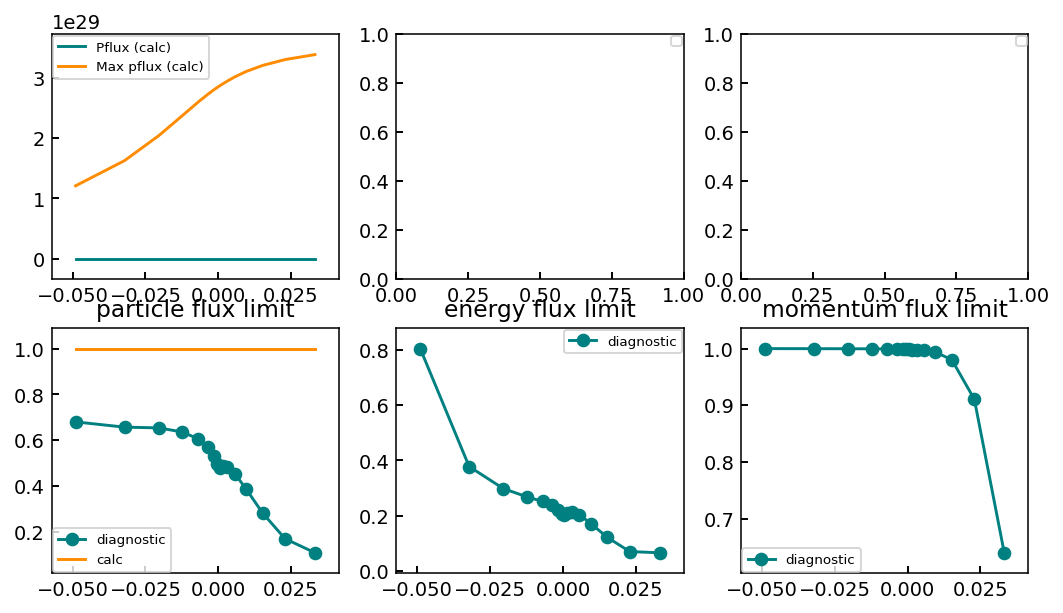

In [13]:
particle_flux_limit_alpha = float(ds.options["d"]["particle_flux_limit_alpha"])
flux_limit_gamma = float(ds.options["d"]["flux_limit_gamma"])

print(f"From options: particle_flux_limit_alpha={particle_flux_limit_alpha}")
print(f"From options: flux_limit_gamma={flux_limit_gamma}")

df["particle_flux_abs_calc"] = df["Nnlim"] * df["Vabs_calc"]
df["particle_limit_calc"] = df["Nd"] * 0.25 * np.sqrt(8 * df["Tnlim"] / (np.pi * Mi))
df["flim_pf_perp_calc"] = (1 + (df["particle_flux_abs_calc"] / (particle_flux_limit_alpha * df["particle_limit_calc"]))**flux_limit_gamma)**(-1/flux_limit_gamma)

fig, axes =plt.subplots(2,3, figsize = (3*3,5))

ax = axes[0,0]
ax.plot(df["Srad"], df["particle_flux_abs_calc"], label = "Pflux (calc)")
ax.plot(df["Srad"], df["particle_limit_calc"], label = "Max pflux (calc)")

ax = axes[1,0]
ax.set_title("particle flux limit")
ax.plot(df["Srad"], df["fluxlimd_pf_perp"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["flim_pf_perp_calc"],  label = "calc")
# ax.plot(df["Srad"], df["Dmax_calc"], "-", label = "calc")

ax = axes[1,1]
ax.set_title("energy flux limit")
ax.plot(df["Srad"], df["fluxlimd_ef_perp"], "o-", label = "diagnostic")
# ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")

ax = axes[1,2]
ax.set_title("momentum flux limit")
ax.plot(df["Srad"], df["fluxlimd_mf_perp"], "o-", label = "diagnostic")
# ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")


for ax in axes.flatten():
    ax.legend(fontsize = "x-small")

In [ ]:
Vector3D Grad_perp(const Field3D& f, CELL_LOC outloc, const std::string& method) {
  TRACE("Grad_perp( Field3D )");
  SCOREP0();
  ASSERT1(outloc == CELL_DEFAULT || outloc == f.getLocation());

  Coordinates* metric = f.getCoordinates(outloc);

  Vector3D result(f.getMesh());

  result.x = DDX(f, outloc, method)
             - metric->g_12 * DDY(f, outloc, method) / SQ(metric->J * metric->Bxy);
  result.y = 0.0;
  result.z = DDZ(f, outloc, method)
             - metric->g_23 * DDY(f, outloc, method) / SQ(metric->J * metric->Bxy);

  result.setLocation(result.x.getLocation());

  result.covariant = true;

  return result;
}

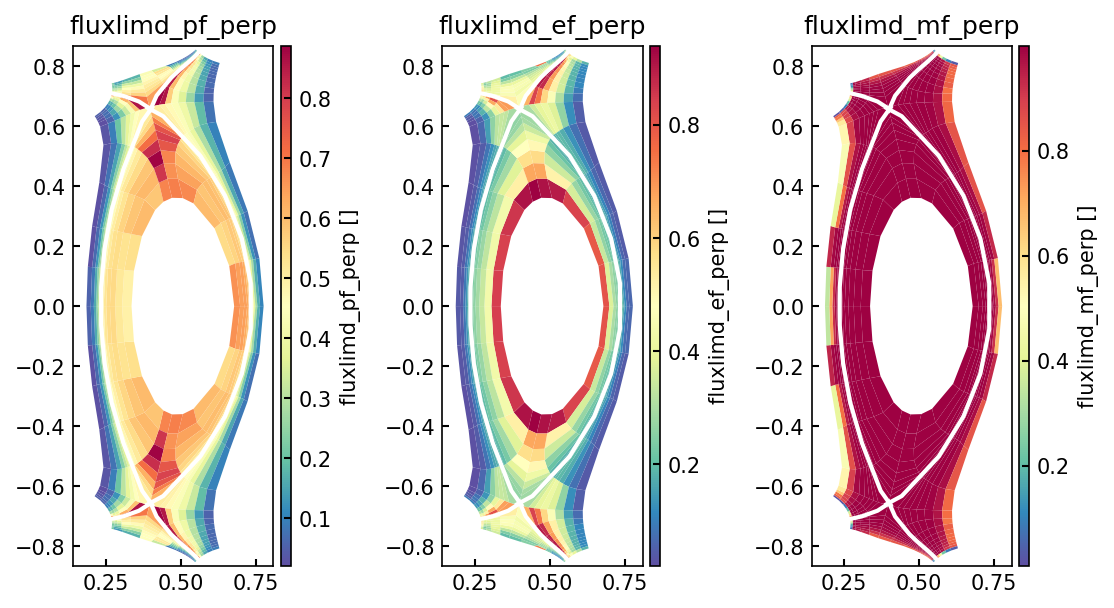

In [57]:
fig, axes = plt.subplots(1,3, figsize = (3.0*3,4.5), dpi = 150)
cmap = "Spectral_r"

name = "new"

ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)

for i, param in enumerate(["fluxlimd_pf_perp", "fluxlimd_ef_perp", "fluxlimd_mf_perp"]):
  
  data = ds[param]
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = False,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")

# Verify flux - new

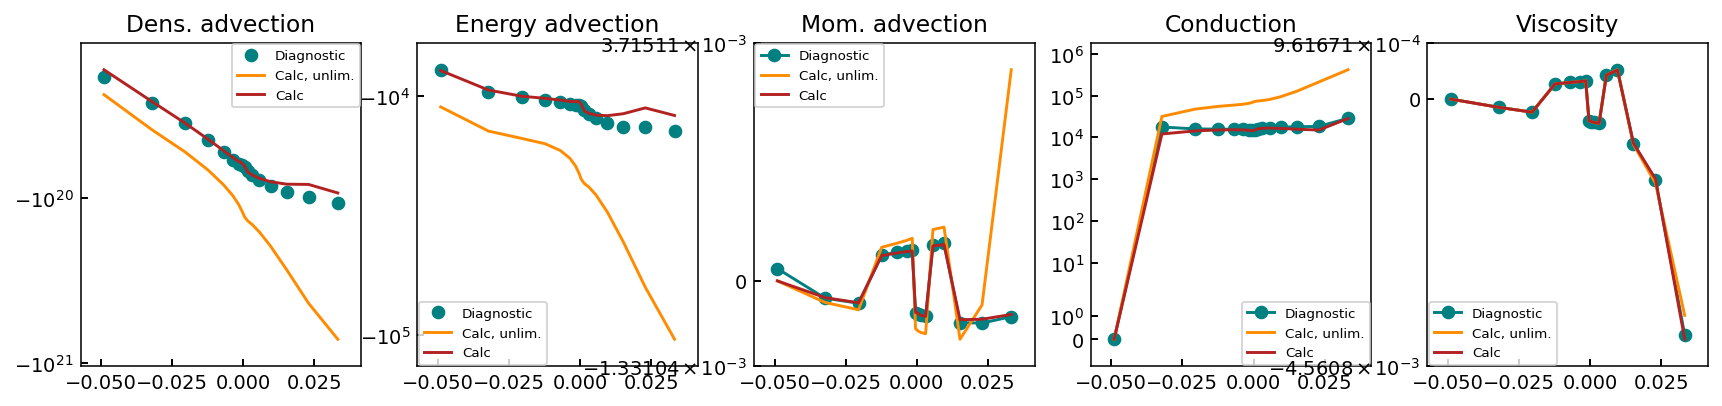

In [14]:
df = dfs["new"]



fig, axes =plt.subplots(1,5, figsize = (3*5,3))

ax = axes[0]
ax.set_title("Dens. advection")
ax.plot(df["Srad"], df["pfd_adv_perp_xlow"], "o", label = "Diagnostic")
ax.plot(df["Srad"], df["pf_adv_calc"], label = "Calc, unlim.")
ax.plot(df["Srad"], df["pf_adv_calc_timeslim"], label = "Calc")
# ax.plot

ax = axes[1]
ax.set_title("Energy advection")
ax.plot(df["Srad"], df["efd_adv_perp_xlow"], "o", label = "Diagnostic")
ax.plot(df["Srad"], df["ef_adv_calc"], label = "Calc, unlim.")
ax.plot(df["Srad"], df["ef_adv_calc_timeslim"], label = "Calc")

ax = axes[2]
ax.set_title("Mom. advection")
ax.plot(df["Srad"], df["mfd_adv_perp_xlow"], "-o", label = "Diagnostic")
ax.plot(df["Srad"], df["mf_adv_calc"], label = "Calc, unlim.")
ax.plot(df["Srad"], df["mf_adv_calc_timeslim"], label = "Calc")

ax = axes[3]
ax.set_title("Conduction")
ax.plot(df["Srad"], df["efd_cond_perp_xlow"], "-o", label = "Diagnostic")
ax.plot(df["Srad"], df["ef_cond_calc"], label = "Calc, unlim.")
ax.plot(df["Srad"], df["ef_cond_calc_timeslim"], label = "Calc")

ax = axes[4]
ax.set_title("Viscosity")
ax.plot(df["Srad"], df["mfd_visc_perp_xlow"], "-o", label = "Diagnostic")
ax.plot(df["Srad"], df["mf_visc_calc"] * constants("mass_p"), label = "Calc, unlim.")
ax.plot(df["Srad"], df["mf_visc_calc_timeslim"] * constants("mass_p"), label = "Calc")


# ax.set_yscale("log")
for ax in axes:
    ax.legend(fontsize = "x-small")
    ax.set_yscale("symlog")

### Dnn

### Flux limiter factors

In [ ]:
fig, axes = plt.subplots(1,5, figsize = (3*5,3))

# Old

In [ ]:
# name = "base"
# df = dfs[name]
# ds = cs[name].ds
# if "t" in ds.sizes: ds = ds.isel(t=-1)
# m = ds.metadata
# Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
# Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
# pn_floor = 1e-8 * 1/100 * Pnorm

# Pnlim = softFloor(ds["Pd"], pn_floor);
# logPnlim = np.log(Pnlim)

# pf_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
# ds["pf_calc"] = (["x", "theta"], pf_xlow.data)

dfs = {}

for name in cs.keys():
    ds = cs[name].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)
    
    m = ds.metadata
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
    pn_floor = 1e-8 * 1/100 * Pnorm

    Pnlim = softFloor(ds["Pd"], pn_floor);
    logPnlim = np.log(Pnlim)
    
    kappa_n = 5/2 * ds["Dnnd"] * ds["Nd"]
    # eta_n = 2*constants("mass_p") * 2/5 * kappa_n
    eta_n = 2/5 * kappa_n
    
    pf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
    mf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["NVd"], logPnlim)
    ef_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Pd"], logPnlim)
    ef_cond_xlow, _ = Div_a_Grad_perp_fast(ds, kappa_n, ds["Td"]*constants("q_e"))
    
    mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, 2 * eta_n, ds["Vd"])
    # mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, eta_n, ds["Vd"])
    
    ef_adv_xlow *= 5/2
    ef_cond_xlow *= 3/2

    
    ds["pf_adv_calc"] = (["x", "theta"], pf_adv_xlow.data)
    ds["mf_adv_calc"] = (["x", "theta"], mf_adv_xlow.data)
    ds["ef_adv_calc"] = (["x", "theta"], ef_adv_xlow.data)
    ds["ef_cond_calc"] = (["x", "theta"], ef_cond_xlow.data)
    ds["mf_visc_calc"] = (["x", "theta"], mf_visc_xlow.data)
    
    if "fluxlimd_pf_perp" in ds:
        ds["pf_adv_calc_timeslim"] = ds["pf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["mf_adv_calc_timeslim"] = ds["mf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_adv_calc_timeslim"] = ds["ef_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_cond_calc_timeslim"] = ds["ef_cond_calc"] * ds["fluxlimd_ef_perp"]
        ds["mf_visc_calc_timeslim"] = ds["mf_visc_calc"] * ds["fluxlimd_mf_perp"]

    
    dfs[name] = get_1d_radial_data(ds, ["pfd_adv_perp_xlow", "mfd_adv_perp_xlow", "efd_adv_perp_xlow", "efd_cond_perp_xlow", "mfd_visc_perp_xlow",
                                        "dy", "dz", "g22", "g_33", "Nd", "Ne", "Pd", "Dnnd", "Dmax", "Td", "Vd", "Vd+",
                                        "Kdd+_cx", "Sd+_iz",
                                        "kappa_n_d",
                                        "flimd_pf_perp", "flimd_ef_perp", "flimd_mf_perp",
                                        # "Vd_perp_x", "Vd_perp_ddx", "gradlogP"
                                        "pf_adv_calc", "mf_adv_calc", "ef_adv_calc", "ef_cond_calc", "mf_visc_calc",
                                        "pf_adv_calc_timeslim", "mf_adv_calc_timeslim", "ef_adv_calc_timeslim", "ef_cond_calc_timeslim", "mf_visc_calc_timeslim",
                                        ], "omp")

    df = dfs[name]
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

    df["dpol"] = df["dy"] * np.sqrt(df["g22"])
    df["dtor"] = df["dz"] * np.sqrt(df["g_33"])
    df["darad"] = df["dpol"] * df["dtor"]
    pn_floor = 1e-8 * 1/100 * Pnorm
    df["Pnlim"] = np.clip(df["Pd"], pn_floor, None)

    df["pflux"] = df["pfd_adv_perp_xlow"] / df["darad"]
    df["logPnlim"] = np.log(df["Pnlim"])
    df["kappa_n"] = 5/2 * df["Dnnd"] * df["Nd"]
    dfs[name] = df

## Transport

In [ ]:
df = dfs["base"]



fig, axes =plt.subplots(1,5, figsize = (3*5,3))

ax = axes[0]
ax.set_title("Dens. advection")
ax.plot(df["Srad"], df["pfd_adv_perp_xlow"], "o", label = "Diagnostic")
ax.plot(df["Srad"], df["pf_adv_calc"], label = "Calc")

ax = axes[1]
ax.set_title("Energy advection")
ax.plot(df["Srad"], df["efd_adv_perp_xlow"], "o", label = "Diagnostic")
ax.plot(df["Srad"], df["ef_adv_calc"], label = "Calc")

ax = axes[2]
ax.set_title("Mom. advection")
ax.plot(df["Srad"], df["mfd_adv_perp_xlow"], "-o", label = "Diagnostic")
ax.plot(df["Srad"], df["mf_adv_calc"], label = "Calc")

ax = axes[3]
ax.set_title("Conduction")
ax.plot(df["Srad"], df["efd_cond_perp_xlow"], "-o", label = "Diagnostic")
ax.plot(df["Srad"], df["ef_cond_calc"], label = "Calc")

ax = axes[4]
ax.set_title("Viscosity")
ax.plot(df["Srad"][1:], df["mfd_visc_perp_xlow"][1:], "-o", label = "Diagnostic")
ax.plot(df["Srad"][1:], df["mf_visc_calc"][1:], label = "Calc")

# ax = axes[5]
# ax.set_title("Vd")
# ax.plot(df["Srad"], df["Vd"], "-o", label = "Diagnostic")
# ax.plot(df["Srad"], df["kappa_n"], label = "Calc")

# ax = axes[5]
# ax.set_title("Temp")
# ax.plot(df["Srad"], df["Td"], "-o", label = "Diagnostic")
# ax.plot(df["Srad"], df["kappa_n"], label = "Calc")
# ax.set_yscale("symlog")



# ax.set_yscale("log")
ax.legend(fontsize = "x-small")

KeyError: 'base'

## Dnn and limiter

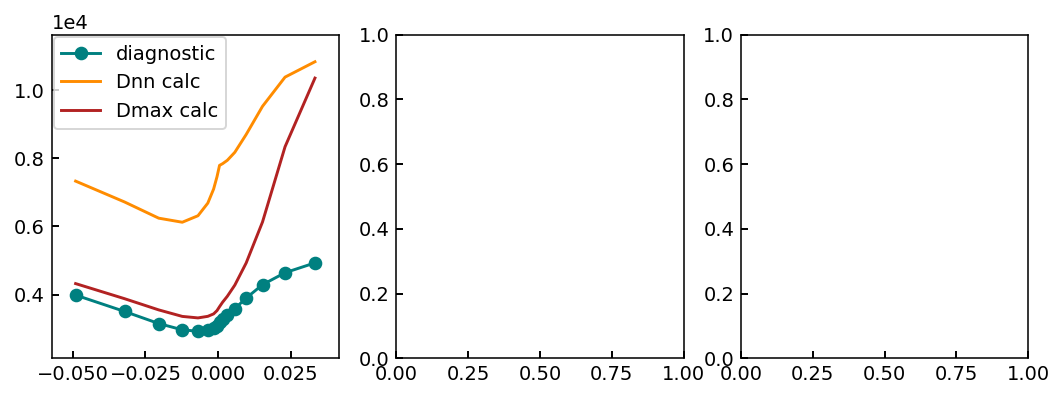

In [ ]:
df = dfs["base"]

temperature_floor = 0.1
neutral_lmax = 0.1
Mi = 2 * constants("mass_p")
flux_limit = 0.2
nu = df["Kdd+_cx"] #+ df["Sd+_iz"]/df["Nd"]

Tnlim = softFloor(df["Td"], 0.1)


df["Rnn"] = np.sqrt(Tnlim*constants("q_e")/Mi) / neutral_lmax
df["Dnn_calc"] = (Tnlim * constants("q_e")/Mi) / (nu + df["Rnn"])
df["Dmax_calc"] = flux_limit * np.sqrt(Tnlim * constants("q_e") / Mi) / (np.gradient(df["logPnlim"], df["Srad"]))

fig, axes =plt.subplots(1,3, figsize = (3*3,3))

ax = axes[0]
ax.plot(df["Srad"], df["Dnnd"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["Dnn_calc"], label = "Dnn calc")
ax.plot(df["Srad"], df["Dmax_calc"], label = "Dmax calc")
ax.legend()